In [1]:
from tensorflow.examples.tutorials.mnist import input_data

import glob
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt


### Raw Input

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting input/fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting input/fashion/train-labels-idx1-ubyte.gz
Extracting input/fashion/t10k-images-idx3-ubyte.gz
Extracting input/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


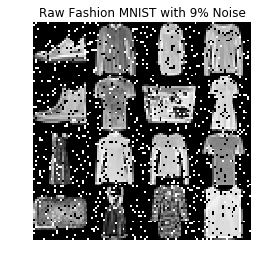

In [2]:
fashion = input_data.read_data_sets('input/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
x_train = fashion.train.images[40:60]
    
def corrupt(X_o,corNum=10):
    X = X_o.copy()
    N,p = X.shape[0],X.shape[1]
    
    for i in range(N):
        loclist = np.random.randint(0, p, size = corNum)
        for j in loclist:
            if X[i,j] > 0.5:
                X[i,j] = 0
            else:
                X[i,j] = 1
    return X

noise_factors = [0.09]
for noise_factor in noise_factors:
    x_train_noisy = corrupt(x_train, corNum = int(noise_factor*784))

    h = w = 28
    # plot of generation
    n = np.sqrt(16).astype(np.int32)
    I_generated = np.empty((h*n, w*n))
    for i in range(n):
        for j in range(n):
            I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_train_noisy[i*n+j, :].reshape(28, 28)

    plt.figure(figsize=(4, 4))
    plt.imshow(I_generated, cmap='gray')
    plt.axis('off')
    plt.title("Raw Fashion MNIST with "+str(int(noise_factor*100))+"% Noise")
#     plt.savefig("./pic/raw_fm_n49")
    plt.show()


### Image Table

In [3]:
def plot(x,title):
    h = w = 28
    # plot of generation
    n = np.sqrt(16).astype(np.int32)
    I_generated = np.empty((h*n, w*n))
    for i in range(n):
        for j in range(n):
            I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x[i*n+j, :].reshape(28, 28)

    plt.figure(figsize=(4, 4))
    plt.imshow(I_generated, cmap='gray')
    plt.axis('off')
    plt.title(title)
#     plt.savefig("./pic/"+title)
    plt.show()

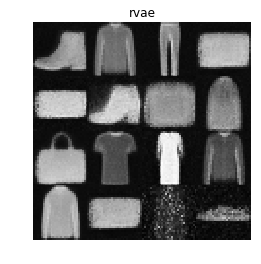

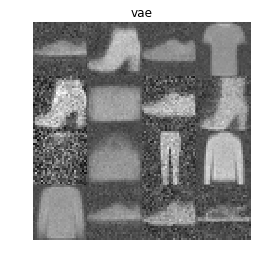

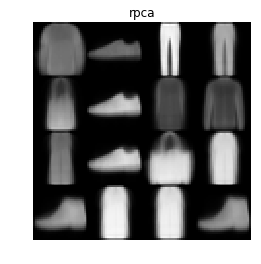

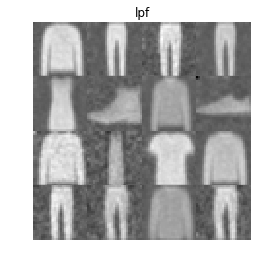

In [4]:
# RVAE
# We select 9% and 41% as examples
rvae = np.load("./rvae_sp_noise/lambda_50/noise_0.41/generation_fid.npy")
plot(rvae,'rvae')

# VAE
vae = np.load("./vae_sp_noise/0.41/generation_fid.npy")
plot(vae,'vae')

# RPCA
rpca = np.load("./rpca_sp_noise/0.41/generation_fid.npy")
plot(rpca,'rpca')

# LPF
lpf = np.load("./fourier_vae_fashion/0.41/generation_fid.npy")
plot(lpf,'lpf')

### FID Heat Map

In [5]:
vae_fid_scores = np.load("fid_scores_vae.npy")
vae_fid_scores.shape

(13,)

In [6]:
rvae_fid_scores = np.load("fid_scores_rvae.npy")
rvae_fid_scores.shape

(10, 13)

In [7]:
rpca_fid_scores = np.load("fid_scores_rpca.npy")
rpca_fid_scores.shape

(13,)

In [8]:
foureir_fid_scores = np.load("fid_scores_foureir_fashion.npy")
foureir_fid_scores.shape

(13,)

In [9]:
lambdas = [1,5,10,15,20,25,50,70,100,250]
noise_factors = [round(0.01*i,2) for i in range(1,51,4)]
len(noise_factors)

13

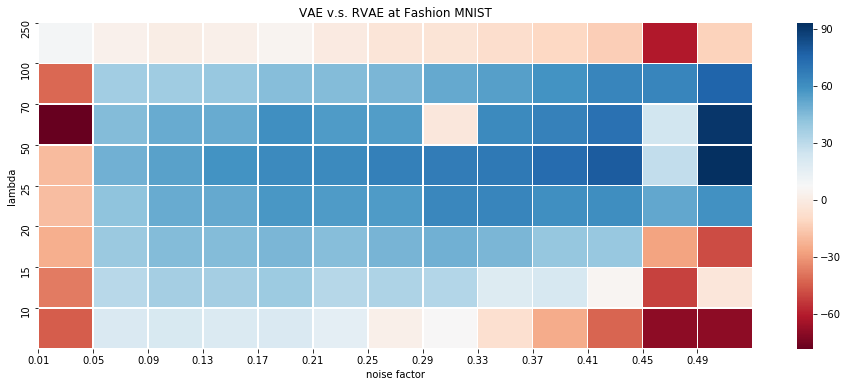

In [10]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap((vae_fid_scores - rvae_fid_scores[2:])[::-1], linewidth=0.5,cmap="RdBu") #bwr

plt.xlabel("noise factor")
plt.ylabel("lambda")
plt.yticks(range(len(lambdas[2:])),lambdas[2:][::-1])
plt.xticks(range(len(noise_factors)),noise_factors)
plt.title("VAE v.s. RVAE at Fashion MNIST")

# plt.savefig("fid_heatmap.png")
plt.show()

### Table of FID Scores

In [11]:
# find the best lambda, i.e. the minimum average fid scores across noise factors
a = [i.mean() for i in rvae_fid_scores]
a.index(np.array(a).min())

6

In [12]:
print(lambdas[6])
rvae_fid_scores[6] # when lambdas = 50

50


array([ 113.38516291,   59.25173023,   68.70174457,   73.25411519,
         82.4310281 ,   88.85581407,   93.62663133,   96.26119586,
        102.42029466,  107.34206879,  111.24050457,  168.75716384,
        120.78119473])

In [13]:
vae_fid_scores

array([  93.80439179,  108.09859064,  122.55201014,  131.7835392 ,
        144.22462787,  150.7439655 ,  159.41153445,  163.63451738,
        170.85825248,  180.76325443,  189.7170525 ,  197.4440234 ,
        213.98974934])

In [14]:
rpca_fid_scores

array([ 174.84010067,  137.97191294,  137.48340303,  140.84473418,
        144.74916368,  146.49154294,  151.92464255,  200.57884681,
        161.18759741,  210.95475467,  165.00753181,  215.14542767,
        172.54373975])

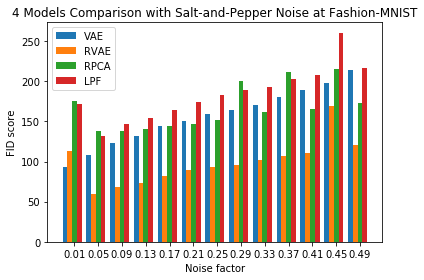

In [15]:
noise_factors = [round(0.01*i,2) for i in range(1,52,4)]
# create plot
fig, ax = plt.subplots()
index = np.arange(len(noise_factors))
bar_width = 0.2
opacity = 1
 
rects1 = plt.bar(index, vae_fid_scores, bar_width,
                 alpha=opacity, label='VAE')
 
rects2 = plt.bar(index + bar_width, rvae_fid_scores[6], bar_width,
                 alpha=opacity, label='RVAE')

rects2 = plt.bar(index + 2*bar_width, rpca_fid_scores, bar_width,
                 alpha=opacity, label='RPCA')

rects2 = plt.bar(index + 3*bar_width, foureir_fid_scores, bar_width,
                 alpha=opacity, label='LPF')
 
plt.xlabel('Noise factor')
plt.ylabel('FID score')
plt.title('4 Models Comparison with Salt-and-Pepper Noise at Fashion-MNIST')
plt.xticks(index + 2*bar_width, noise_factors)
plt.legend()
 
plt.tight_layout()
# plt.savefig("../gs_pic/gs_vae_rvae_bar.png")
plt.show()